In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel('TelcoChurn.xlsx')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.shape

(7043, 21)

In [5]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [10]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
# Customer ID is uniwue for each customer and will not be helpful in prediction
data.drop('customerID',axis=1,inplace=True)
data.shape

(7043, 20)

In [13]:
# Dependent variable churn is Yes or No which needs to be converted into numeric form for modelling
data['target'] = np.where(data['Churn']=='Yes',1,0)
data.drop('Churn',axis=1,inplace=True)

In [14]:
data.target.value_counts()

0    5174
1    1869
Name: target, dtype: int64

In [15]:
y = data[['target']]
X = data.drop('target',axis=1)


In [16]:
# Finding the churn rate
y.mean()

target    0.26537
dtype: float64

In [18]:
# Splitting into numerical and categorical 

num = X.select_dtypes(include="number")
cat = X.select_dtypes(include="object")

In [19]:
num.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [20]:
num.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

In [22]:
# Although SeniorCitizen column datatype in integer but its working as categorical variable
ind = num[['SeniorCitizen']]
num.drop('SeniorCitizen',axis=1,inplace=True)

In [23]:
ind.head()

,SeniorCitizen
0,0
1,0
2,0
3,0
4,0


***Outlier Removal***

In [24]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.9,0.99])

# In case of TotalCharges 99% of data is less than 8039 but 1% data is greater than 8039

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.798992
std,24.559481,30.090047,2266.730170
min,0.000000,18.250000,18.800000
1%,1.000000,19.200000,19.871000
5%,1.000000,19.650000,49.070000
10%,2.000000,20.050000,83.470000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000


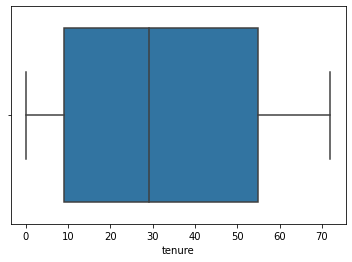

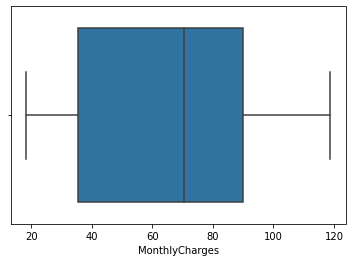

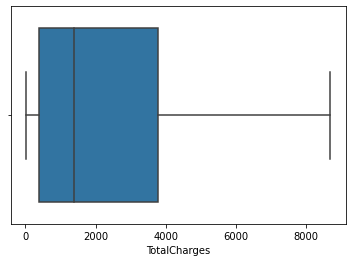

In [28]:
for i in num.columns:
  sns.boxplot(num[i])
  plt.show()

In [29]:
# method to remove first and last 1% of any variable
# Although as pre boxplot most significant data is Q3-Q1, if we take that data only standard deviation will change significantly
def outlier_remove(x):
  x = x.clip(lower=x.quantile(0.01))
  x = x.clip(upper=x.quantile(0.99))
  return x

In [30]:
num = num.apply(lambda x:outlier_remove(x))

Remove features with zero varience

In [34]:
from sklearn.feature_selection import VarianceThreshold
varselector = VarianceThreshold(threshold=0)
varselector.fit_transform(num)
cols = varselector.get_support(indices=True)
num_1 = num.iloc[:,cols]

In [35]:
# Here no columns are dropped as none ishaving zero varience
num_1.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


**Bivariate Analysis (Numeric Data)**

In [36]:
# Binning numeric columns into 10 bins based on quartiles and encoding them as well
from sklearn.preprocessing import KBinsDiscretizer
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')
num_binned=pd.DataFrame(discrete.fit_transform(num_1),index=num_1.index, columns=num_1.columns).add_suffix('_Rank')
num_binned.head()

,tenure_Rank,MonthlyCharges_Rank,TotalCharges_Rank
0,0.0,2.0,0.0
1,5.0,3.0,5.0
2,1.0,3.0,1.0
3,6.0,2.0,5.0
4,1.0,5.0,1.0


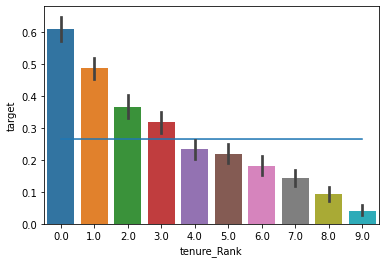

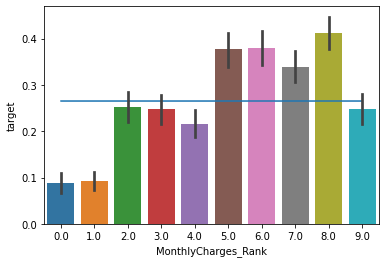

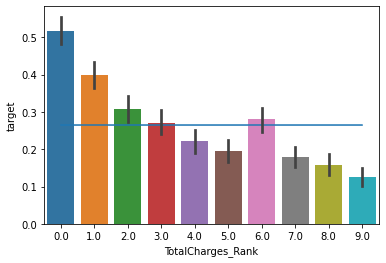

In [38]:
# A strong slope is indicative of the features' ability to discriminate the event from non event
# making it a good predictor
# Hence, tenure_rank and total_charges_rank are very good predictors
# Monthly_charges_rank although not as good as other two can prove helpful so not dropping that

X_bin_combined=pd.concat([y,num_binned],axis=1,join='inner')

from numpy import mean
for col in (num_binned.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_bin_combined['target'].mean(),data=X_bin_combined)
    sns.barplot(x=col, y="target",data=X_bin_combined, estimator=mean )
plt.show()

In [55]:
select_features_df_num=num_1

In [56]:
select_features_df_num.shape

(7043, 3)

**Bivariate Analysis (categorical Data)**

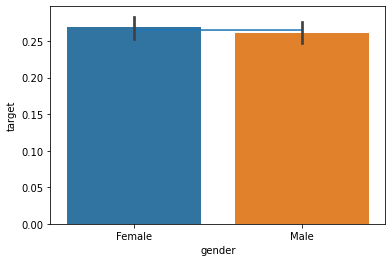

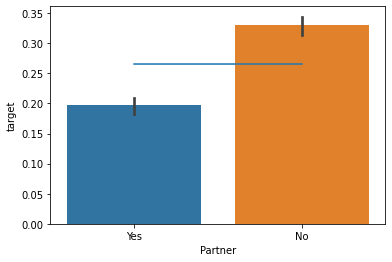

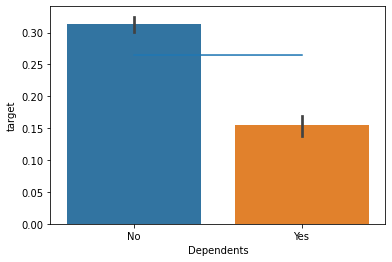

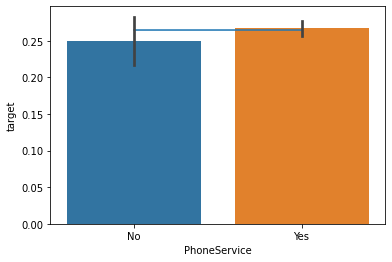

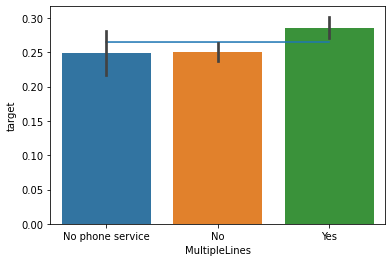

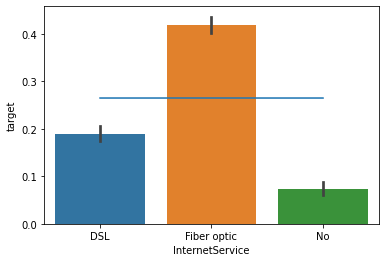

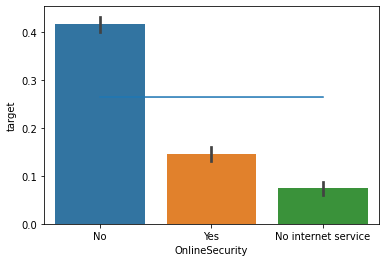

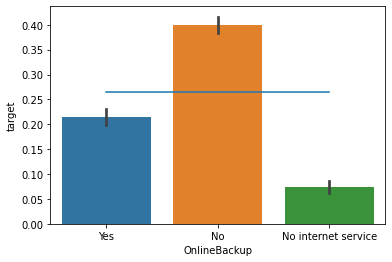

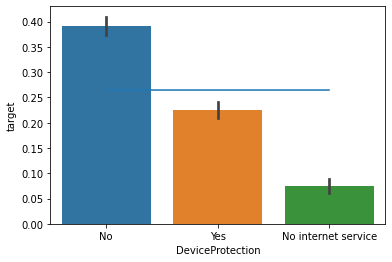

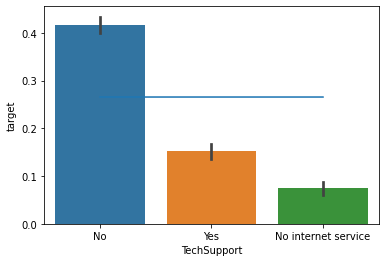

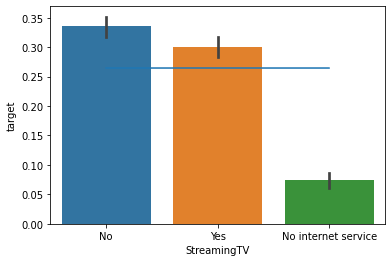

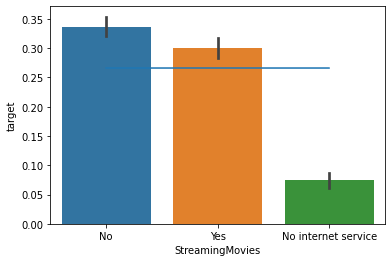

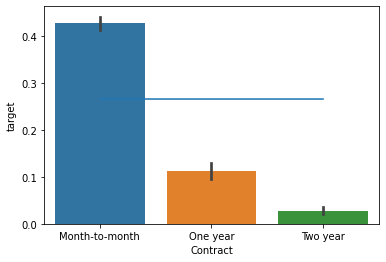

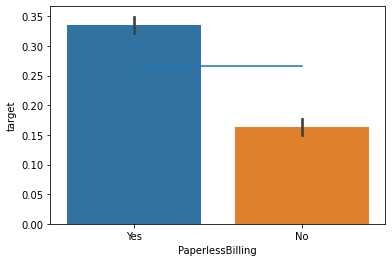

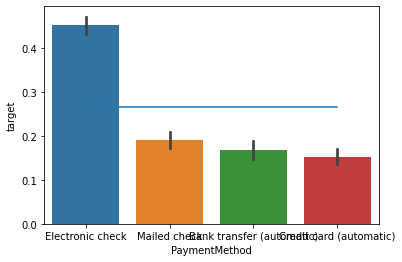

In [41]:
X_char_merged=pd.concat([y,cat],axis=1,join='inner')

from numpy import mean
for col in (cat.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_char_merged['target'].mean(),data=X_char_merged)
    sns.barplot(x=col, y="target",data=X_char_merged, estimator=mean )
plt.show()

In [43]:
# From above visualization gender,PhoneService,MultipleLines are not good predictors

cat=cat.drop(['gender','PhoneService','MultipleLines'],axis=1)

In [44]:
# Create dummy features with n-1 levels

X_char_dum = pd.get_dummies(cat, drop_first = True)
X_char_dum.shape

(7043, 22)

Selecting K best features

In [46]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20)
selector.fit_transform(X_char_dum, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_char = X_char_dum.iloc[:,cols]

In [48]:
select_features_df_char.shape

# As we have selectes 20 best features, 2 out of 22 are dropped

(7043, 20)

In [49]:
select_features_df_char.dtypes

Partner_Yes                              uint8
Dependents_Yes                           uint8
InternetService_Fiber optic              uint8
InternetService_No                       uint8
OnlineSecurity_No internet service       uint8
OnlineSecurity_Yes                       uint8
OnlineBackup_No internet service         uint8
OnlineBackup_Yes                         uint8
DeviceProtection_No internet service     uint8
DeviceProtection_Yes                     uint8
TechSupport_No internet service          uint8
TechSupport_Yes                          uint8
StreamingTV_No internet service          uint8
StreamingMovies_No internet service      uint8
Contract_One year                        uint8
Contract_Two year                        uint8
PaperlessBilling_Yes                     uint8
PaymentMethod_Credit card (automatic)    uint8
PaymentMethod_Electronic check           uint8
PaymentMethod_Mailed check               uint8
dtype: object

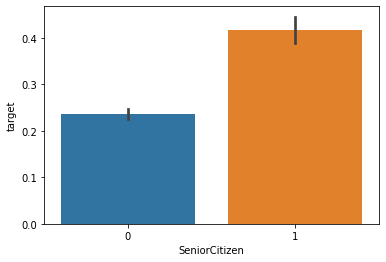

In [52]:
# Senios citizen columns is left whose dtype ws int32 but its categorical

X_ind_merged=pd.concat([y,ind],axis=1,join='inner')
from numpy import mean
for col in (ind.columns):
    plt.figure()
    sns.barplot(x=col, y="target",data=X_ind_merged, estimator=mean )
plt.show()

In [53]:
select_features_df_ind=ind

In [57]:
X_all=pd.concat([select_features_df_char,select_features_df_num,select_features_df_ind],axis=1,join="inner")

In [58]:
X_all.shape

(7043, 24)